# Análise de Risco de Crédito

In [41]:
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline

import talos as ta

from imblearn.over_sampling import RandomOverSampler

from keras.activations import sigmoid
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.losses import mean_squared_error
from keras.models import Sequential
from keras.optimizers import SGD

from numpy import concatenate, vstack, argmin

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from talos.model.early_stopper import early_stopper
from talos.model.normalizers import lr_normalizer

In [3]:
# Construir DataFrame a partir da base de dados.
data_set = pd.read_csv('data/TRN', sep='\t', index_col=0)

In [4]:
# Exibe as 5 primeiras linhas da base de dados.
data_set.head(5)

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
INDEX,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,0,1,1,0,1,1,1,0,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,0,1,0,1,1,0,0,0,1,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,1,0,0,0,0,1,0,1,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,1,0,1,1,0,1,0,1,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,1,0,0,1,0,1,1,0


In [5]:
# Separa as classes em DataFrames distintos.
class_1_df = data_set.loc[data_set['IND_BOM_1_2'] == 0] # Bom pagador.
class_2_df = data_set.loc[data_set['IND_BOM_1_2'] == 1] # Mau pagador.

In [6]:
# Separa "features" dos "targets" para cada classe, transformando-os em numpy arrays.
class_1_X = class_1_df.iloc[:, :-2].values
class_1_y = class_1_df.iloc[:, -1].values

class_2_X = class_2_df.iloc[:, :-2].values
class_2_y = class_2_df.iloc[:, -1].values

In [7]:
# Treino: 50%, Validação: 25%, Teste: 25% (para ambas as classes).
class_1_X_train, class_1_X_test, class_1_y_train, class_1_y_test = train_test_split(
    class_1_X, class_1_y, test_size=0.25, random_state=42, stratify=class_1_y)

class_1_X_train, class_1_X_val, class_1_y_train, class_1_y_val = train_test_split(
    class_1_X_train, class_1_y_train, test_size=(1./3), random_state=42, stratify=class_1_y_train)

class_2_X_train, class_2_X_test, class_2_y_train, class_2_y_test = train_test_split(
    class_2_X, class_2_y, test_size=0.25, random_state=42, stratify=class_2_y)

class_2_X_train, class_2_X_val, class_2_y_train, class_2_y_val = train_test_split(
    class_2_X_train, class_2_y_train, test_size=(1./3), random_state=42, stratify=class_2_y_train)

In [8]:
# Concatena os arrays de treinamento das classes (features e targets).
X_train = vstack((class_1_X_train, class_2_X_train))
y_train = concatenate([class_1_y_train, class_2_y_train])

# Concatena os arrays de validação das classes (features e targets).
X_val = vstack((class_1_X_val, class_2_X_val))
y_val = concatenate([class_1_y_val, class_2_y_val])

# Concatena os arrays de teste das classes (features e targets).
X_test = vstack((class_1_X_test, class_2_X_test))
y_test = concatenate([class_1_y_test, class_2_y_test])

In [9]:
# Over-sampling os conjuntos de treinamento e validação da classe 2 (minoritária).
ros = RandomOverSampler(random_state=0)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_val_resampled, y_val_resampled = ros.fit_resample(X_val, y_val)

In [ ]:
# Aleatorização (passo desnecessário pois o Keras embaralha por padrão no método "fit")
# X_train, y_train = shuffle(X_train_resampled, y_train_resampled, random_state=42)
# X_val, y_val = shuffle(X_val_resampled, y_val_resampled, random_state=42)
# X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [40]:
def credit_risk_analisys_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    
    model.add(Dense(params['first_neuron'], activation='tanh', input_dim=x_train.shape[1]))
    
    model.add(Dense(1, activation=params['last_activation']))
              
    model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['loss'],
                  metrics=['acc'])

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    validation_data=[x_val, y_val],
                    verbose=2,
                    callbacks=early_stopper(params['epochs'], mode='strict'))

    return out, model

In [48]:
p = {'lr': [0.01, 0.1, 0.5, 1.0, 1.5, 3.0],
     'first_neuron':[2, 32, 128, 256],
     'batch_size': [64],
     'epochs': [100000],
     'optimizer': [SGD],
     'loss': [mean_squared_error],
     'last_activation': [sigmoid]}

In [ ]:
h = ta.Scan(x=X_train, y=y_train, params=p,
            x_val=X_val, y_val=y_val,
            dataset_name='credit_risk_analisys',
            experiment_no='1',
            model=credit_risk_analisys_model)

  0%|                                                                       | 0/24 [00:00<?, ?it/s]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 8s - loss: 0.2156 - acc: 0.6583 - val_loss: 0.2107 - val_acc: 0.6655
Epoch 2/100000
 - 8s - loss: 0.2095 - acc: 0.6675 - val_loss: 0.2086 - val_acc: 0.6692
Epoch 3/100000
 - 7s - loss: 0.2081 - acc: 0.6705 - val_loss: 0.2078 - val_acc: 0.6702
Epoch 4/100000
 - 7s - loss: 0.2073 - acc: 0.6720 - val_loss: 0.2076 - val_acc: 0.6720
Epoch 5/100000
 - 8s - loss: 0.2069 - acc: 0.6730 - val_loss: 0.2068 - val_acc: 0.6729
Epoch 6/100000
 - 8s - loss: 0.2065 - acc: 0.6738 - val_loss: 0.2067 - val_acc: 0.6739
Epoch 7/100000
 - 7s - loss: 0.2061 - acc: 0.6740 - val_loss: 0.2064 - val_acc: 0.6739
Epoch 8/100000
 - 7s - loss: 0.2059 - acc: 0.6752 - val_loss: 0.2062 - val_acc: 0.6749
Epoch 9/100000
 - 8s - loss: 0.2056 - acc: 0.6760 - val_loss: 0.2059 - val_acc: 0.6756
Epoch 10/100000
 - 7s - loss: 0.2053 - acc: 0.6764 - val_loss: 0.2058 - val_acc: 0.6752
Epoch 11/100000
 - 8s - loss: 0.2051 - acc: 0.6773 - val_loss: 0.2057 - val_ac

  4%|██▌                                                           | 1/24 [01:52<43:01, 112.23s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 7s - loss: 0.2246 - acc: 0.6536 - val_loss: 0.2208 - val_acc: 0.6566
Epoch 2/100000
 - 7s - loss: 0.2178 - acc: 0.6582 - val_loss: 0.2153 - val_acc: 0.6607
Epoch 3/100000
 - 7s - loss: 0.2134 - acc: 0.6630 - val_loss: 0.2123 - val_acc: 0.6637
Epoch 4/100000
 - 7s - loss: 0.2110 - acc: 0.6664 - val_loss: 0.2107 - val_acc: 0.6663
Epoch 5/100000
 - 7s - loss: 0.2097 - acc: 0.6686 - val_loss: 0.2097 - val_acc: 0.6671
Epoch 6/100000
 - 7s - loss: 0.2088 - acc: 0.6697 - val_loss: 0.2090 - val_acc: 0.6689
Epoch 7/100000
 - 7s - loss: 0.2083 - acc: 0.6711 - val_loss: 0.2089 - val_acc: 0.6687
Epoch 8/100000
 - 7s - loss: 0.2079 - acc: 0.6709 - val_loss: 0.2082 - val_acc: 0.6705
Epoch 9/100000
 - 7s - loss: 0.2076 - acc: 0.6722 - val_loss: 0.2079 - val_acc: 0.6710
Epoch 10/100000
 - 6s - loss: 0.2073 - acc: 0.6729 - val_loss: 0.2077 - val_acc: 0.6716
Epoch 11/100000
 - 7s - loss: 0.2071 - acc: 0.6731 - val_loss: 0.2088 - val_ac

  8%|█████▏                                                        | 2/24 [04:28<46:01, 125.54s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 9s - loss: 0.2287 - acc: 0.6395 - val_loss: 0.2251 - val_acc: 0.6486
Epoch 2/100000
 - 10s - loss: 0.2235 - acc: 0.6505 - val_loss: 0.2217 - val_acc: 0.6524
Epoch 3/100000
 - 9s - loss: 0.2206 - acc: 0.6532 - val_loss: 0.2194 - val_acc: 0.6550
Epoch 4/100000
 - 9s - loss: 0.2185 - acc: 0.6551 - val_loss: 0.2176 - val_acc: 0.6569
Epoch 5/100000
 - 9s - loss: 0.2170 - acc: 0.6566 - val_loss: 0.2163 - val_acc: 0.6588
Epoch 6/100000
 - 9s - loss: 0.2158 - acc: 0.6581 - val_loss: 0.2152 - val_acc: 0.6602
Epoch 7/100000
 - 9s - loss: 0.2149 - acc: 0.6596 - val_loss: 0.2144 - val_acc: 0.6612
Epoch 8/100000
 - 9s - loss: 0.2141 - acc: 0.6608 - val_loss: 0.2137 - val_acc: 0.6621
Epoch 9/100000
 - 10s - loss: 0.2134 - acc: 0.6621 - val_loss: 0.2131 - val_acc: 0.6631
Epoch 10/100000
 - 10s - loss: 0.2129 - acc: 0.6628 - val_loss: 0.2126 - val_acc: 0.6638
Epoch 11/100000
 - 10s - loss: 0.2124 - acc: 0.6634 - val_loss: 0.2122 - va

Epoch 94/100000
 - 8s - loss: 0.2063 - acc: 0.6753 - val_loss: 0.2068 - val_acc: 0.6735
Epoch 95/100000
 - 7s - loss: 0.2062 - acc: 0.6751 - val_loss: 0.2068 - val_acc: 0.6736
Epoch 96/100000
 - 8s - loss: 0.2062 - acc: 0.6752 - val_loss: 0.2068 - val_acc: 0.6737
Epoch 97/100000
 - 7s - loss: 0.2062 - acc: 0.6753 - val_loss: 0.2068 - val_acc: 0.6740
Epoch 98/100000
 - 7s - loss: 0.2062 - acc: 0.6755 - val_loss: 0.2068 - val_acc: 0.6738
Epoch 99/100000
 - 7s - loss: 0.2062 - acc: 0.6755 - val_loss: 0.2068 - val_acc: 0.6736
Epoch 100/100000
 - 8s - loss: 0.2062 - acc: 0.6756 - val_loss: 0.2068 - val_acc: 0.6744
Epoch 101/100000
 - 8s - loss: 0.2061 - acc: 0.6757 - val_loss: 0.2067 - val_acc: 0.6734
Epoch 102/100000
 - 6s - loss: 0.2061 - acc: 0.6754 - val_loss: 0.2067 - val_acc: 0.6738
Epoch 103/100000
 - 7s - loss: 0.2061 - acc: 0.6758 - val_loss: 0.2067 - val_acc: 0.6738
Epoch 104/100000
 - 8s - loss: 0.2061 - acc: 0.6755 - val_loss: 0.2067 - val_acc: 0.6738
Epoch 105/100000
 - 7s - lo

 12%|███████▌                                                    | 3/24 [19:54<2:07:54, 365.47s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 6s - loss: 0.2253 - acc: 0.6484 - val_loss: 0.2210 - val_acc: 0.6551
Epoch 2/100000
 - 6s - loss: 0.2195 - acc: 0.6551 - val_loss: 0.2178 - val_acc: 0.6561
Epoch 3/100000
 - 6s - loss: 0.2168 - acc: 0.6565 - val_loss: 0.2155 - val_acc: 0.6580
Epoch 4/100000
 - 6s - loss: 0.2148 - acc: 0.6590 - val_loss: 0.2140 - val_acc: 0.6617
Epoch 5/100000
 - 6s - loss: 0.2134 - acc: 0.6614 - val_loss: 0.2129 - val_acc: 0.6620
Epoch 6/100000
 - 6s - loss: 0.2124 - acc: 0.6629 - val_loss: 0.2120 - val_acc: 0.6649
Epoch 7/100000
 - 7s - loss: 0.2116 - acc: 0.6650 - val_loss: 0.2114 - val_acc: 0.6655
Epoch 8/100000
 - 7s - loss: 0.2110 - acc: 0.6658 - val_loss: 0.2109 - val_acc: 0.6669
Epoch 9/100000
 - 6s - loss: 0.2105 - acc: 0.6670 - val_loss: 0.2105 - val_acc: 0.6675
Epoch 10/100000
 - 7s - loss: 0.2101 - acc: 0.6681 - val_loss: 0.2101 - val_acc: 0.6680
Epoch 11/100000
 - 7s - loss: 0.2097 - acc: 0.6682 - val_loss: 0.2099 - val_ac

 17%|██████████                                                  | 4/24 [23:41<1:48:03, 324.17s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 6s - loss: 0.2193 - acc: 0.6538 - val_loss: 0.2134 - val_acc: 0.6612
Epoch 2/100000
 - 6s - loss: 0.2114 - acc: 0.6646 - val_loss: 0.2104 - val_acc: 0.6660
Epoch 3/100000
 - 6s - loss: 0.2094 - acc: 0.6678 - val_loss: 0.2093 - val_acc: 0.6674
Epoch 4/100000
 - 6s - loss: 0.2084 - acc: 0.6700 - val_loss: 0.2084 - val_acc: 0.6695
Epoch 5/100000
 - 6s - loss: 0.2078 - acc: 0.6707 - val_loss: 0.2079 - val_acc: 0.6709
Epoch 6/100000
 - 7s - loss: 0.2074 - acc: 0.6716 - val_loss: 0.2076 - val_acc: 0.6710
Epoch 7/100000
 - 7s - loss: 0.2071 - acc: 0.6723 - val_loss: 0.2075 - val_acc: 0.6712
Epoch 8/100000
 - 8s - loss: 0.2068 - acc: 0.6729 - val_loss: 0.2072 - val_acc: 0.6729
Epoch 9/100000
 - 7s - loss: 0.2066 - acc: 0.6737 - val_loss: 0.2074 - val_acc: 0.6712
Epoch 10/100000
 - 7s - loss: 0.2064 - acc: 0.6745 - val_loss: 0.2067 - val_acc: 0.6732
Epoch 11/100000
 - 7s - loss: 0.2062 - acc: 0.6749 - val_loss: 0.2067 - val_ac

 21%|████████████▌                                               | 5/24 [26:05<1:25:29, 269.96s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 9s - loss: 0.2133 - acc: 0.6628 - val_loss: 0.2097 - val_acc: 0.6679
Epoch 2/100000
 - 9s - loss: 0.2084 - acc: 0.6708 - val_loss: 0.2092 - val_acc: 0.6689
Epoch 3/100000
 - 9s - loss: 0.2074 - acc: 0.6722 - val_loss: 0.2078 - val_acc: 0.6715
Epoch 4/100000
 - 9s - loss: 0.2069 - acc: 0.6736 - val_loss: 0.2069 - val_acc: 0.6741
Epoch 5/100000
 - 9s - loss: 0.2065 - acc: 0.6744 - val_loss: 0.2065 - val_acc: 0.6755
Epoch 6/100000
 - 9s - loss: 0.2063 - acc: 0.6751 - val_loss: 0.2073 - val_acc: 0.6735
Epoch 7/100000
 - 9s - loss: 0.2061 - acc: 0.6761 - val_loss: 0.2084 - val_acc: 0.6698


 25%|███████████████                                             | 6/24 [27:10<1:02:34, 208.59s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 10s - loss: 0.2147 - acc: 0.6598 - val_loss: 0.2100 - val_acc: 0.6666
Epoch 2/100000
 - 9s - loss: 0.2091 - acc: 0.6683 - val_loss: 0.2084 - val_acc: 0.6707
Epoch 3/100000
 - 9s - loss: 0.2080 - acc: 0.6704 - val_loss: 0.2076 - val_acc: 0.6714
Epoch 4/100000
 - 9s - loss: 0.2074 - acc: 0.6721 - val_loss: 0.2072 - val_acc: 0.6720
Epoch 5/100000
 - 8s - loss: 0.2070 - acc: 0.6728 - val_loss: 0.2069 - val_acc: 0.6729
Epoch 6/100000
 - 9s - loss: 0.2066 - acc: 0.6740 - val_loss: 0.2066 - val_acc: 0.6745
Epoch 7/100000
 - 8s - loss: 0.2064 - acc: 0.6745 - val_loss: 0.2068 - val_acc: 0.6730
Epoch 8/100000
 - 8s - loss: 0.2063 - acc: 0.6748 - val_loss: 0.2068 - val_acc: 0.6728


 29%|██████████████████                                            | 7/24 [28:24<47:37, 168.07s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 6s - loss: 0.2224 - acc: 0.6527 - val_loss: 0.2169 - val_acc: 0.6580
Epoch 2/100000
 - 6s - loss: 0.2139 - acc: 0.6624 - val_loss: 0.2118 - val_acc: 0.6651
Epoch 3/100000
 - 6s - loss: 0.2105 - acc: 0.6674 - val_loss: 0.2098 - val_acc: 0.6675
Epoch 4/100000
 - 6s - loss: 0.2090 - acc: 0.6704 - val_loss: 0.2088 - val_acc: 0.6695
Epoch 5/100000
 - 6s - loss: 0.2082 - acc: 0.6715 - val_loss: 0.2082 - val_acc: 0.6708
Epoch 6/100000
 - 7s - loss: 0.2077 - acc: 0.6723 - val_loss: 0.2080 - val_acc: 0.6705
Epoch 7/100000
 - 8s - loss: 0.2073 - acc: 0.6728 - val_loss: 0.2084 - val_acc: 0.6705
Epoch 8/100000
 - 7s - loss: 0.2071 - acc: 0.6727 - val_loss: 0.2074 - val_acc: 0.6725
Epoch 9/100000
 - 7s - loss: 0.2069 - acc: 0.6733 - val_loss: 0.2075 - val_acc: 0.6726
Epoch 10/100000
 - 7s - loss: 0.2067 - acc: 0.6741 - val_loss: 0.2070 - val_acc: 0.6731
Epoch 11/100000
 - 8s - loss: 0.2066 - acc: 0.6744 - val_loss: 0.2071 - val_ac

 33%|████████████████████▋                                         | 8/24 [30:10<39:51, 149.50s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 10s - loss: 0.2119 - acc: 0.6647 - val_loss: 0.2091 - val_acc: 0.6682
Epoch 2/100000
 - 10s - loss: 0.2080 - acc: 0.6708 - val_loss: 0.2072 - val_acc: 0.6730
Epoch 3/100000
 - 10s - loss: 0.2072 - acc: 0.6723 - val_loss: 0.2079 - val_acc: 0.6714
Epoch 4/100000
 - 10s - loss: 0.2069 - acc: 0.6737 - val_loss: 0.2066 - val_acc: 0.6743
Epoch 5/100000
 - 10s - loss: 0.2065 - acc: 0.6746 - val_loss: 0.2064 - val_acc: 0.6746
Epoch 6/100000
 - 10s - loss: 0.2063 - acc: 0.6753 - val_loss: 0.2064 - val_acc: 0.6747
Epoch 7/100000
 - 10s - loss: 0.2061 - acc: 0.6751 - val_loss: 0.2069 - val_acc: 0.6738


 38%|███████████████████████▎                                      | 9/24 [31:25<31:46, 127.07s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 7s - loss: 0.2256 - acc: 0.6458 - val_loss: 0.2192 - val_acc: 0.6545
Epoch 2/100000
 - 9s - loss: 0.2168 - acc: 0.6574 - val_loss: 0.2148 - val_acc: 0.6592
Epoch 3/100000
 - 8s - loss: 0.2137 - acc: 0.6613 - val_loss: 0.2126 - val_acc: 0.6623
Epoch 4/100000
 - 8s - loss: 0.2120 - acc: 0.6633 - val_loss: 0.2114 - val_acc: 0.6642
Epoch 5/100000
 - 8s - loss: 0.2108 - acc: 0.6653 - val_loss: 0.2106 - val_acc: 0.6660
Epoch 6/100000
 - 8s - loss: 0.2101 - acc: 0.6665 - val_loss: 0.2099 - val_acc: 0.6671
Epoch 7/100000
 - 9s - loss: 0.2095 - acc: 0.6676 - val_loss: 0.2094 - val_acc: 0.6679
Epoch 8/100000
 - 8s - loss: 0.2090 - acc: 0.6684 - val_loss: 0.2091 - val_acc: 0.6687
Epoch 9/100000
 - 7s - loss: 0.2087 - acc: 0.6695 - val_loss: 0.2088 - val_acc: 0.6693
Epoch 10/100000
 - 8s - loss: 0.2084 - acc: 0.6696 - val_loss: 0.2085 - val_acc: 0.6698
Epoch 11/100000
 - 7s - loss: 0.2081 - acc: 0.6702 - val_loss: 0.2083 - val_ac

 42%|█████████████████████████▍                                   | 10/24 [37:46<47:26, 203.32s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 7s - loss: 0.2163 - acc: 0.6598 - val_loss: 0.2107 - val_acc: 0.6664
Epoch 2/100000
 - 6s - loss: 0.2094 - acc: 0.6688 - val_loss: 0.2089 - val_acc: 0.6698
Epoch 3/100000
 - 7s - loss: 0.2081 - acc: 0.6717 - val_loss: 0.2078 - val_acc: 0.6718
Epoch 4/100000
 - 8s - loss: 0.2074 - acc: 0.6726 - val_loss: 0.2084 - val_acc: 0.6696
Epoch 5/100000
 - 7s - loss: 0.2070 - acc: 0.6736 - val_loss: 0.2070 - val_acc: 0.6739
Epoch 6/100000
 - 7s - loss: 0.2068 - acc: 0.6739 - val_loss: 0.2068 - val_acc: 0.6747
Epoch 7/100000
 - 7s - loss: 0.2066 - acc: 0.6741 - val_loss: 0.2070 - val_acc: 0.6736
Epoch 8/100000
 - 6s - loss: 0.2064 - acc: 0.6748 - val_loss: 0.2081 - val_acc: 0.6709


 46%|███████████████████████████▉                                 | 11/24 [38:45<34:38, 159.91s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 11s - loss: 0.2213 - acc: 0.6539 - val_loss: 0.2148 - val_acc: 0.6597
Epoch 2/100000
 - 11s - loss: 0.2127 - acc: 0.6632 - val_loss: 0.2117 - val_acc: 0.6646
Epoch 3/100000
 - 11s - loss: 0.2105 - acc: 0.6661 - val_loss: 0.2101 - val_acc: 0.6665
Epoch 4/100000
 - 9s - loss: 0.2095 - acc: 0.6680 - val_loss: 0.2094 - val_acc: 0.6682
Epoch 5/100000
 - 10s - loss: 0.2088 - acc: 0.6691 - val_loss: 0.2089 - val_acc: 0.6691
Epoch 6/100000
 - 11s - loss: 0.2083 - acc: 0.6703 - val_loss: 0.2086 - val_acc: 0.6697
Epoch 7/100000
 - 11s - loss: 0.2079 - acc: 0.6706 - val_loss: 0.2082 - val_acc: 0.6703
Epoch 8/100000
 - 10s - loss: 0.2076 - acc: 0.6710 - val_loss: 0.2079 - val_acc: 0.6714
Epoch 9/100000
 - 11s - loss: 0.2074 - acc: 0.6720 - val_loss: 0.2080 - val_acc: 0.6712
Epoch 10/100000
 - 11s - loss: 0.2072 - acc: 0.6720 - val_loss: 0.2076 - val_acc: 0.6719
Epoch 11/100000
 - 11s - loss: 0.2070 - acc: 0.6731 - val_loss: 0.207

 50%|██████████████████████████████▌                              | 12/24 [42:09<34:40, 173.37s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 8s - loss: 0.2775 - acc: 0.4734 - val_loss: 0.2455 - val_acc: 0.5703
Epoch 2/100000
 - 8s - loss: 0.2381 - acc: 0.6059 - val_loss: 0.2351 - val_acc: 0.6239
Epoch 3/100000
 - 8s - loss: 0.2337 - acc: 0.6314 - val_loss: 0.2334 - val_acc: 0.6358
Epoch 4/100000
 - 8s - loss: 0.2327 - acc: 0.6387 - val_loss: 0.2327 - val_acc: 0.6399
Epoch 5/100000
 - 7s - loss: 0.2321 - acc: 0.6412 - val_loss: 0.2321 - val_acc: 0.6423
Epoch 6/100000
 - 7s - loss: 0.2316 - acc: 0.6426 - val_loss: 0.2316 - val_acc: 0.6432
Epoch 7/100000
 - 8s - loss: 0.2311 - acc: 0.6436 - val_loss: 0.2311 - val_acc: 0.6440
Epoch 8/100000
 - 7s - loss: 0.2306 - acc: 0.6444 - val_loss: 0.2306 - val_acc: 0.6447
Epoch 9/100000
 - 8s - loss: 0.2302 - acc: 0.6453 - val_loss: 0.2302 - val_acc: 0.6453
Epoch 10/100000
 - 8s - loss: 0.2297 - acc: 0.6457 - val_loss: 0.2298 - val_acc: 0.6460
Epoch 11/100000
 - 7s - loss: 0.2293 - acc: 0.6464 - val_loss: 0.2294 - val_ac

Epoch 94/100000
 - 8s - loss: 0.2158 - acc: 0.6593 - val_loss: 0.2161 - val_acc: 0.6596
Epoch 95/100000
 - 8s - loss: 0.2158 - acc: 0.6594 - val_loss: 0.2161 - val_acc: 0.6597
Epoch 96/100000
 - 8s - loss: 0.2157 - acc: 0.6593 - val_loss: 0.2160 - val_acc: 0.6597
Epoch 97/100000
 - 8s - loss: 0.2156 - acc: 0.6593 - val_loss: 0.2159 - val_acc: 0.6598
Epoch 98/100000
 - 8s - loss: 0.2156 - acc: 0.6594 - val_loss: 0.2159 - val_acc: 0.6600
Epoch 99/100000
 - 8s - loss: 0.2155 - acc: 0.6596 - val_loss: 0.2158 - val_acc: 0.6600
Epoch 100/100000
 - 8s - loss: 0.2154 - acc: 0.6597 - val_loss: 0.2157 - val_acc: 0.6600
Epoch 101/100000
 - 8s - loss: 0.2154 - acc: 0.6597 - val_loss: 0.2157 - val_acc: 0.6600
Epoch 102/100000
 - 8s - loss: 0.2153 - acc: 0.6598 - val_loss: 0.2156 - val_acc: 0.6600
Epoch 103/100000
 - 7s - loss: 0.2152 - acc: 0.6600 - val_loss: 0.2156 - val_acc: 0.6601
Epoch 104/100000
 - 8s - loss: 0.2152 - acc: 0.6600 - val_loss: 0.2155 - val_acc: 0.6601
Epoch 105/100000
 - 8s - lo

Epoch 186/100000
 - 8s - loss: 0.2118 - acc: 0.6650 - val_loss: 0.2123 - val_acc: 0.6638
Epoch 187/100000
 - 8s - loss: 0.2118 - acc: 0.6651 - val_loss: 0.2123 - val_acc: 0.6638
Epoch 188/100000
 - 7s - loss: 0.2118 - acc: 0.6650 - val_loss: 0.2122 - val_acc: 0.6637
Epoch 189/100000
 - 8s - loss: 0.2118 - acc: 0.6649 - val_loss: 0.2122 - val_acc: 0.6638
Epoch 190/100000
 - 8s - loss: 0.2117 - acc: 0.6651 - val_loss: 0.2122 - val_acc: 0.6637
Epoch 191/100000
 - 8s - loss: 0.2117 - acc: 0.6650 - val_loss: 0.2122 - val_acc: 0.6639
Epoch 192/100000
 - 8s - loss: 0.2117 - acc: 0.6651 - val_loss: 0.2121 - val_acc: 0.6639
Epoch 193/100000
 - 8s - loss: 0.2117 - acc: 0.6652 - val_loss: 0.2121 - val_acc: 0.6640
Epoch 194/100000
 - 7s - loss: 0.2116 - acc: 0.6651 - val_loss: 0.2121 - val_acc: 0.6642
Epoch 195/100000
 - 7s - loss: 0.2116 - acc: 0.6652 - val_loss: 0.2121 - val_acc: 0.6643
Epoch 196/100000
 - 8s - loss: 0.2116 - acc: 0.6653 - val_loss: 0.2120 - val_acc: 0.6642
Epoch 197/100000
 - 8

Epoch 278/100000
 - 8s - loss: 0.2101 - acc: 0.6677 - val_loss: 0.2106 - val_acc: 0.6673
Epoch 279/100000
 - 8s - loss: 0.2100 - acc: 0.6679 - val_loss: 0.2106 - val_acc: 0.6673
Epoch 280/100000
 - 7s - loss: 0.2100 - acc: 0.6679 - val_loss: 0.2106 - val_acc: 0.6673
Epoch 281/100000
 - 8s - loss: 0.2100 - acc: 0.6679 - val_loss: 0.2105 - val_acc: 0.6674
Epoch 282/100000
 - 8s - loss: 0.2100 - acc: 0.6680 - val_loss: 0.2105 - val_acc: 0.6674
Epoch 283/100000
 - 8s - loss: 0.2100 - acc: 0.6680 - val_loss: 0.2105 - val_acc: 0.6675
Epoch 284/100000
 - 8s - loss: 0.2100 - acc: 0.6679 - val_loss: 0.2105 - val_acc: 0.6676
Epoch 285/100000
 - 7s - loss: 0.2100 - acc: 0.6679 - val_loss: 0.2105 - val_acc: 0.6676
Epoch 286/100000
 - 8s - loss: 0.2099 - acc: 0.6680 - val_loss: 0.2105 - val_acc: 0.6677
Epoch 287/100000
 - 7s - loss: 0.2099 - acc: 0.6680 - val_loss: 0.2105 - val_acc: 0.6677
Epoch 288/100000
 - 8s - loss: 0.2099 - acc: 0.6681 - val_loss: 0.2104 - val_acc: 0.6678
Epoch 289/100000
 - 8

Epoch 370/100000
 - 8s - loss: 0.2090 - acc: 0.6698 - val_loss: 0.2096 - val_acc: 0.6691
Epoch 371/100000
 - 8s - loss: 0.2090 - acc: 0.6698 - val_loss: 0.2096 - val_acc: 0.6692
Epoch 372/100000
 - 8s - loss: 0.2090 - acc: 0.6698 - val_loss: 0.2096 - val_acc: 0.6691
Epoch 373/100000
 - 8s - loss: 0.2090 - acc: 0.6698 - val_loss: 0.2096 - val_acc: 0.6691
Epoch 374/100000
 - 7s - loss: 0.2090 - acc: 0.6700 - val_loss: 0.2096 - val_acc: 0.6691
Epoch 375/100000
 - 7s - loss: 0.2090 - acc: 0.6698 - val_loss: 0.2096 - val_acc: 0.6691
Epoch 376/100000
 - 8s - loss: 0.2090 - acc: 0.6699 - val_loss: 0.2096 - val_acc: 0.6691
Epoch 377/100000
 - 8s - loss: 0.2090 - acc: 0.6699 - val_loss: 0.2095 - val_acc: 0.6691
Epoch 378/100000
 - 8s - loss: 0.2090 - acc: 0.6699 - val_loss: 0.2095 - val_acc: 0.6691
Epoch 379/100000
 - 8s - loss: 0.2090 - acc: 0.6699 - val_loss: 0.2095 - val_acc: 0.6691
Epoch 380/100000
 - 8s - loss: 0.2089 - acc: 0.6699 - val_loss: 0.2095 - val_acc: 0.6691
Epoch 381/100000
 - 8

Epoch 462/100000
 - 7s - loss: 0.2084 - acc: 0.6712 - val_loss: 0.2090 - val_acc: 0.6695
Epoch 463/100000
 - 9s - loss: 0.2084 - acc: 0.6714 - val_loss: 0.2090 - val_acc: 0.6695
Epoch 464/100000
 - 8s - loss: 0.2083 - acc: 0.6713 - val_loss: 0.2090 - val_acc: 0.6696
Epoch 465/100000
 - 8s - loss: 0.2083 - acc: 0.6713 - val_loss: 0.2089 - val_acc: 0.6694
Epoch 466/100000
 - 8s - loss: 0.2083 - acc: 0.6714 - val_loss: 0.2089 - val_acc: 0.6695
Epoch 467/100000
 - 8s - loss: 0.2083 - acc: 0.6713 - val_loss: 0.2089 - val_acc: 0.6695
Epoch 468/100000
 - 8s - loss: 0.2083 - acc: 0.6714 - val_loss: 0.2089 - val_acc: 0.6696
Epoch 469/100000
 - 7s - loss: 0.2083 - acc: 0.6714 - val_loss: 0.2089 - val_acc: 0.6696
Epoch 470/100000
 - 8s - loss: 0.2083 - acc: 0.6714 - val_loss: 0.2089 - val_acc: 0.6696
Epoch 471/100000
 - 8s - loss: 0.2083 - acc: 0.6713 - val_loss: 0.2089 - val_acc: 0.6697
Epoch 472/100000
 - 8s - loss: 0.2083 - acc: 0.6714 - val_loss: 0.2089 - val_acc: 0.6697
Epoch 473/100000
 - 8

Epoch 554/100000
 - 8s - loss: 0.2079 - acc: 0.6720 - val_loss: 0.2085 - val_acc: 0.6706
Epoch 555/100000
 - 8s - loss: 0.2079 - acc: 0.6719 - val_loss: 0.2085 - val_acc: 0.6706
Epoch 556/100000
 - 8s - loss: 0.2079 - acc: 0.6719 - val_loss: 0.2085 - val_acc: 0.6705
Epoch 557/100000
 - 8s - loss: 0.2079 - acc: 0.6719 - val_loss: 0.2085 - val_acc: 0.6705
Epoch 558/100000
 - 7s - loss: 0.2079 - acc: 0.6720 - val_loss: 0.2085 - val_acc: 0.6706
Epoch 559/100000
 - 8s - loss: 0.2078 - acc: 0.6720 - val_loss: 0.2085 - val_acc: 0.6707
Epoch 560/100000
 - 8s - loss: 0.2078 - acc: 0.6720 - val_loss: 0.2085 - val_acc: 0.6706
Epoch 561/100000
 - 8s - loss: 0.2078 - acc: 0.6720 - val_loss: 0.2085 - val_acc: 0.6707
Epoch 562/100000
 - 8s - loss: 0.2078 - acc: 0.6721 - val_loss: 0.2085 - val_acc: 0.6706
Epoch 563/100000
 - 8s - loss: 0.2078 - acc: 0.6720 - val_loss: 0.2085 - val_acc: 0.6706
Epoch 564/100000
 - 8s - loss: 0.2078 - acc: 0.6720 - val_loss: 0.2085 - val_acc: 0.6706
Epoch 565/100000
 - 8

Epoch 646/100000
 - 8s - loss: 0.2075 - acc: 0.6726 - val_loss: 0.2082 - val_acc: 0.6712
Epoch 647/100000
 - 8s - loss: 0.2075 - acc: 0.6726 - val_loss: 0.2082 - val_acc: 0.6713
Epoch 648/100000
 - 8s - loss: 0.2075 - acc: 0.6726 - val_loss: 0.2082 - val_acc: 0.6713
Epoch 649/100000
 - 7s - loss: 0.2075 - acc: 0.6727 - val_loss: 0.2081 - val_acc: 0.6712
Epoch 650/100000
 - 8s - loss: 0.2075 - acc: 0.6725 - val_loss: 0.2081 - val_acc: 0.6713
Epoch 651/100000
 - 8s - loss: 0.2075 - acc: 0.6727 - val_loss: 0.2081 - val_acc: 0.6712
Epoch 652/100000
 - 7s - loss: 0.2075 - acc: 0.6727 - val_loss: 0.2081 - val_acc: 0.6712
Epoch 653/100000
 - 8s - loss: 0.2075 - acc: 0.6727 - val_loss: 0.2081 - val_acc: 0.6712
Epoch 654/100000
 - 8s - loss: 0.2075 - acc: 0.6727 - val_loss: 0.2081 - val_acc: 0.6714
Epoch 655/100000
 - 8s - loss: 0.2075 - acc: 0.6727 - val_loss: 0.2081 - val_acc: 0.6713
Epoch 656/100000
 - 8s - loss: 0.2075 - acc: 0.6727 - val_loss: 0.2081 - val_acc: 0.6713
Epoch 657/100000
 - 8

Epoch 738/100000
 - 8s - loss: 0.2072 - acc: 0.6734 - val_loss: 0.2079 - val_acc: 0.6720
Epoch 739/100000
 - 8s - loss: 0.2072 - acc: 0.6735 - val_loss: 0.2079 - val_acc: 0.6719
Epoch 740/100000
 - 8s - loss: 0.2072 - acc: 0.6734 - val_loss: 0.2079 - val_acc: 0.6720
Epoch 741/100000
 - 8s - loss: 0.2072 - acc: 0.6735 - val_loss: 0.2079 - val_acc: 0.6720
Epoch 742/100000
 - 8s - loss: 0.2072 - acc: 0.6734 - val_loss: 0.2079 - val_acc: 0.6719
Epoch 743/100000
 - 7s - loss: 0.2072 - acc: 0.6734 - val_loss: 0.2079 - val_acc: 0.6720
Epoch 744/100000
 - 8s - loss: 0.2072 - acc: 0.6734 - val_loss: 0.2079 - val_acc: 0.6719
Epoch 745/100000
 - 8s - loss: 0.2072 - acc: 0.6733 - val_loss: 0.2079 - val_acc: 0.6721
Epoch 746/100000
 - 8s - loss: 0.2072 - acc: 0.6735 - val_loss: 0.2079 - val_acc: 0.6719
Epoch 747/100000
 - 8s - loss: 0.2072 - acc: 0.6735 - val_loss: 0.2079 - val_acc: 0.6721
Epoch 748/100000
 - 8s - loss: 0.2072 - acc: 0.6734 - val_loss: 0.2079 - val_acc: 0.6721
Epoch 749/100000
 - 8

Epoch 830/100000
 - 8s - loss: 0.2070 - acc: 0.6739 - val_loss: 0.2076 - val_acc: 0.6726
Epoch 831/100000
 - 8s - loss: 0.2070 - acc: 0.6739 - val_loss: 0.2076 - val_acc: 0.6727
Epoch 832/100000
 - 8s - loss: 0.2070 - acc: 0.6739 - val_loss: 0.2076 - val_acc: 0.6727
Epoch 833/100000
 - 8s - loss: 0.2070 - acc: 0.6740 - val_loss: 0.2076 - val_acc: 0.6726
Epoch 834/100000
 - 8s - loss: 0.2070 - acc: 0.6739 - val_loss: 0.2076 - val_acc: 0.6725
Epoch 835/100000
 - 7s - loss: 0.2069 - acc: 0.6740 - val_loss: 0.2076 - val_acc: 0.6727
Epoch 836/100000
 - 8s - loss: 0.2069 - acc: 0.6739 - val_loss: 0.2076 - val_acc: 0.6726
Epoch 837/100000
 - 8s - loss: 0.2069 - acc: 0.6740 - val_loss: 0.2076 - val_acc: 0.6727
Epoch 838/100000
 - 7s - loss: 0.2069 - acc: 0.6738 - val_loss: 0.2076 - val_acc: 0.6727
Epoch 839/100000
 - 8s - loss: 0.2069 - acc: 0.6739 - val_loss: 0.2076 - val_acc: 0.6727
Epoch 840/100000
 - 8s - loss: 0.2069 - acc: 0.6740 - val_loss: 0.2076 - val_acc: 0.6727
Epoch 841/100000
 - 8

Epoch 922/100000
 - 8s - loss: 0.2068 - acc: 0.6744 - val_loss: 0.2075 - val_acc: 0.6728
Epoch 923/100000
 - 9s - loss: 0.2068 - acc: 0.6742 - val_loss: 0.2075 - val_acc: 0.6730
Epoch 924/100000
 - 7s - loss: 0.2068 - acc: 0.6744 - val_loss: 0.2075 - val_acc: 0.6730
Epoch 925/100000
 - 8s - loss: 0.2068 - acc: 0.6744 - val_loss: 0.2074 - val_acc: 0.6729
Epoch 926/100000
 - 8s - loss: 0.2067 - acc: 0.6744 - val_loss: 0.2074 - val_acc: 0.6729
Epoch 927/100000
 - 8s - loss: 0.2067 - acc: 0.6743 - val_loss: 0.2074 - val_acc: 0.6729
Epoch 928/100000
 - 8s - loss: 0.2067 - acc: 0.6744 - val_loss: 0.2074 - val_acc: 0.6730
Epoch 929/100000
 - 8s - loss: 0.2067 - acc: 0.6743 - val_loss: 0.2074 - val_acc: 0.6730
Epoch 930/100000
 - 8s - loss: 0.2067 - acc: 0.6742 - val_loss: 0.2074 - val_acc: 0.6729
Epoch 931/100000
 - 8s - loss: 0.2067 - acc: 0.6743 - val_loss: 0.2074 - val_acc: 0.6729
Epoch 932/100000
 - 8s - loss: 0.2067 - acc: 0.6744 - val_loss: 0.2074 - val_acc: 0.6729
Epoch 933/100000
 - 8

Epoch 1014/100000
 - 8s - loss: 0.2066 - acc: 0.6747 - val_loss: 0.2073 - val_acc: 0.6735
Epoch 1015/100000
 - 8s - loss: 0.2066 - acc: 0.6747 - val_loss: 0.2073 - val_acc: 0.6735
Epoch 1016/100000
 - 8s - loss: 0.2066 - acc: 0.6747 - val_loss: 0.2073 - val_acc: 0.6734
Epoch 1017/100000
 - 8s - loss: 0.2066 - acc: 0.6747 - val_loss: 0.2073 - val_acc: 0.6734
Epoch 1018/100000
 - 8s - loss: 0.2066 - acc: 0.6747 - val_loss: 0.2073 - val_acc: 0.6736
Epoch 1019/100000
 - 7s - loss: 0.2066 - acc: 0.6748 - val_loss: 0.2073 - val_acc: 0.6736
Epoch 1020/100000
 - 8s - loss: 0.2066 - acc: 0.6747 - val_loss: 0.2073 - val_acc: 0.6735
Epoch 1021/100000
 - 8s - loss: 0.2066 - acc: 0.6747 - val_loss: 0.2073 - val_acc: 0.6735
Epoch 1022/100000
 - 8s - loss: 0.2066 - acc: 0.6747 - val_loss: 0.2073 - val_acc: 0.6735
Epoch 1023/100000
 - 8s - loss: 0.2066 - acc: 0.6747 - val_loss: 0.2073 - val_acc: 0.6735
Epoch 1024/100000
 - 8s - loss: 0.2066 - acc: 0.6747 - val_loss: 0.2073 - val_acc: 0.6736
Epoch 1025

Epoch 1105/100000
 - 8s - loss: 0.2064 - acc: 0.6750 - val_loss: 0.2071 - val_acc: 0.6737
Epoch 1106/100000
 - 8s - loss: 0.2064 - acc: 0.6751 - val_loss: 0.2071 - val_acc: 0.6737
Epoch 1107/100000
 - 8s - loss: 0.2064 - acc: 0.6752 - val_loss: 0.2071 - val_acc: 0.6736
Epoch 1108/100000
 - 8s - loss: 0.2064 - acc: 0.6751 - val_loss: 0.2071 - val_acc: 0.6736
Epoch 1109/100000
 - 8s - loss: 0.2064 - acc: 0.6749 - val_loss: 0.2071 - val_acc: 0.6737
Epoch 1110/100000
 - 8s - loss: 0.2064 - acc: 0.6751 - val_loss: 0.2071 - val_acc: 0.6736
Epoch 1111/100000
 - 8s - loss: 0.2064 - acc: 0.6751 - val_loss: 0.2071 - val_acc: 0.6737
Epoch 1112/100000
 - 8s - loss: 0.2064 - acc: 0.6751 - val_loss: 0.2071 - val_acc: 0.6737
Epoch 1113/100000
 - 8s - loss: 0.2064 - acc: 0.6749 - val_loss: 0.2071 - val_acc: 0.6738
Epoch 1114/100000
 - 8s - loss: 0.2064 - acc: 0.6750 - val_loss: 0.2071 - val_acc: 0.6736
Epoch 1115/100000
 - 8s - loss: 0.2064 - acc: 0.6751 - val_loss: 0.2071 - val_acc: 0.6737
Epoch 1116

Epoch 1196/100000
 - 7s - loss: 0.2063 - acc: 0.6754 - val_loss: 0.2070 - val_acc: 0.6739
Epoch 1197/100000
 - 8s - loss: 0.2063 - acc: 0.6755 - val_loss: 0.2070 - val_acc: 0.6740
Epoch 1198/100000
 - 8s - loss: 0.2063 - acc: 0.6754 - val_loss: 0.2070 - val_acc: 0.6739
Epoch 1199/100000
 - 8s - loss: 0.2063 - acc: 0.6754 - val_loss: 0.2070 - val_acc: 0.6741
Epoch 1200/100000
 - 8s - loss: 0.2063 - acc: 0.6754 - val_loss: 0.2070 - val_acc: 0.6740
Epoch 1201/100000
 - 8s - loss: 0.2063 - acc: 0.6754 - val_loss: 0.2070 - val_acc: 0.6740
Epoch 1202/100000
 - 8s - loss: 0.2063 - acc: 0.6754 - val_loss: 0.2070 - val_acc: 0.6740
Epoch 1203/100000
 - 8s - loss: 0.2063 - acc: 0.6755 - val_loss: 0.2070 - val_acc: 0.6740
Epoch 1204/100000
 - 8s - loss: 0.2063 - acc: 0.6752 - val_loss: 0.2070 - val_acc: 0.6740
Epoch 1205/100000
 - 8s - loss: 0.2063 - acc: 0.6754 - val_loss: 0.2070 - val_acc: 0.6740
Epoch 1206/100000
 - 8s - loss: 0.2063 - acc: 0.6755 - val_loss: 0.2070 - val_acc: 0.6740
Epoch 1207

 54%|██████████████████████████████▎                         | 13/24 [3:22:32<9:11:28, 3008.08s/it]

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 7s - loss: 0.2701 - acc: 0.4606 - val_loss: 0.2455 - val_acc: 0.5578
Epoch 2/100000
 - 7s - loss: 0.2365 - acc: 0.6036 - val_loss: 0.2305 - val_acc: 0.6317
Epoch 3/100000
 - 7s - loss: 0.2288 - acc: 0.6409 - val_loss: 0.2271 - val_acc: 0.6471
Epoch 4/100000
 - 8s - loss: 0.2268 - acc: 0.6497 - val_loss: 0.2260 - val_acc: 0.6508
Epoch 5/100000
 - 7s - loss: 0.2260 - acc: 0.6522 - val_loss: 0.2256 - val_acc: 0.6523
Epoch 6/100000
 - 7s - loss: 0.2257 - acc: 0.6532 - val_loss: 0.2253 - val_acc: 0.6530
Epoch 7/100000
 - 6s - loss: 0.2255 - acc: 0.6538 - val_loss: 0.2251 - val_acc: 0.6535
Epoch 8/100000
 - 6s - loss: 0.2253 - acc: 0.6540 - val_loss: 0.2250 - val_acc: 0.6537
Epoch 9/100000
 - 8s - loss: 0.2252 - acc: 0.6542 - val_loss: 0.2249 - val_acc: 0.6538
Epoch 10/100000
 - 7s - loss: 0.2251 - acc: 0.6544 - val_loss: 0.2248 - val_acc: 0.6539
Epoch 11/100000
 - 7s - loss: 0.2250 - acc: 0.6544 - val_loss: 0.2248 - val_ac

Epoch 94/100000
 - 7s - loss: 0.2192 - acc: 0.6559 - val_loss: 0.2190 - val_acc: 0.6550
Epoch 95/100000
 - 7s - loss: 0.2191 - acc: 0.6560 - val_loss: 0.2189 - val_acc: 0.6550
Epoch 96/100000
 - 7s - loss: 0.2190 - acc: 0.6560 - val_loss: 0.2188 - val_acc: 0.6550
Epoch 97/100000
 - 7s - loss: 0.2190 - acc: 0.6560 - val_loss: 0.2188 - val_acc: 0.6549
Epoch 98/100000
 - 7s - loss: 0.2189 - acc: 0.6561 - val_loss: 0.2187 - val_acc: 0.6549
Epoch 99/100000
 - 8s - loss: 0.2188 - acc: 0.6562 - val_loss: 0.2186 - val_acc: 0.6551
Epoch 100/100000
 - 7s - loss: 0.2188 - acc: 0.6561 - val_loss: 0.2186 - val_acc: 0.6552
Epoch 101/100000
 - 7s - loss: 0.2187 - acc: 0.6562 - val_loss: 0.2185 - val_acc: 0.6553
Epoch 102/100000
 - 7s - loss: 0.2186 - acc: 0.6560 - val_loss: 0.2185 - val_acc: 0.6555
Epoch 103/100000
 - 7s - loss: 0.2186 - acc: 0.6561 - val_loss: 0.2184 - val_acc: 0.6556
Epoch 104/100000
 - 8s - loss: 0.2185 - acc: 0.6562 - val_loss: 0.2183 - val_acc: 0.6557
Epoch 105/100000
 - 8s - lo

Epoch 186/100000
 - 7s - loss: 0.2144 - acc: 0.6605 - val_loss: 0.2144 - val_acc: 0.6600
Epoch 187/100000
 - 7s - loss: 0.2144 - acc: 0.6605 - val_loss: 0.2144 - val_acc: 0.6601
Epoch 188/100000
 - 7s - loss: 0.2144 - acc: 0.6605 - val_loss: 0.2144 - val_acc: 0.6601
Epoch 189/100000
 - 7s - loss: 0.2143 - acc: 0.6607 - val_loss: 0.2143 - val_acc: 0.6601
Epoch 190/100000
 - 7s - loss: 0.2143 - acc: 0.6607 - val_loss: 0.2143 - val_acc: 0.6601
Epoch 191/100000
 - 7s - loss: 0.2143 - acc: 0.6608 - val_loss: 0.2143 - val_acc: 0.6602
Epoch 192/100000
 - 7s - loss: 0.2142 - acc: 0.6608 - val_loss: 0.2142 - val_acc: 0.6601
Epoch 193/100000
 - 7s - loss: 0.2142 - acc: 0.6609 - val_loss: 0.2142 - val_acc: 0.6602
Epoch 194/100000
 - 7s - loss: 0.2142 - acc: 0.6610 - val_loss: 0.2142 - val_acc: 0.6603
Epoch 195/100000
 - 8s - loss: 0.2141 - acc: 0.6610 - val_loss: 0.2141 - val_acc: 0.6603
Epoch 196/100000
 - 7s - loss: 0.2141 - acc: 0.6613 - val_loss: 0.2141 - val_acc: 0.6603
Epoch 197/100000
 - 7

Epoch 278/100000
 - 8s - loss: 0.2119 - acc: 0.6646 - val_loss: 0.2121 - val_acc: 0.6640
Epoch 279/100000
 - 7s - loss: 0.2119 - acc: 0.6647 - val_loss: 0.2120 - val_acc: 0.6640
Epoch 280/100000
 - 7s - loss: 0.2119 - acc: 0.6647 - val_loss: 0.2120 - val_acc: 0.6641
Epoch 281/100000
 - 7s - loss: 0.2119 - acc: 0.6648 - val_loss: 0.2120 - val_acc: 0.6641
Epoch 282/100000
 - 7s - loss: 0.2119 - acc: 0.6648 - val_loss: 0.2120 - val_acc: 0.6642
Epoch 283/100000
 - 8s - loss: 0.2118 - acc: 0.6648 - val_loss: 0.2120 - val_acc: 0.6642
Epoch 284/100000
 - 7s - loss: 0.2118 - acc: 0.6649 - val_loss: 0.2119 - val_acc: 0.6642
Epoch 285/100000
 - 8s - loss: 0.2118 - acc: 0.6646 - val_loss: 0.2119 - val_acc: 0.6641
Epoch 286/100000
 - 7s - loss: 0.2118 - acc: 0.6649 - val_loss: 0.2119 - val_acc: 0.6642
Epoch 287/100000
 - 7s - loss: 0.2118 - acc: 0.6648 - val_loss: 0.2119 - val_acc: 0.6642
Epoch 288/100000
 - 7s - loss: 0.2117 - acc: 0.6649 - val_loss: 0.2119 - val_acc: 0.6643
Epoch 289/100000
 - 8

In [29]:
# use Scan object as input
r = ta.Reporting(h)

# use filename as input
r = ta.Reporting('credit_risk_analisys_1.csv')

In [33]:
# get the highest result ('val_acc' by default)
r.high()

0.6719321685514862

C:\Users\Carlos\Anaconda3\envs\IF702-redes-neurais\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Carlos\Anaconda3\envs\IF702-redes-neurais\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


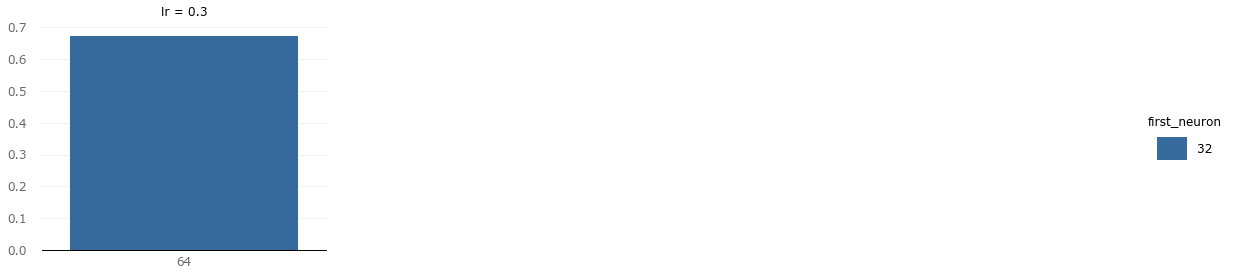

In [47]:
# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'lr')